In [1]:
# 請先使用 transform.py 把原本的數據轉換得到 convert_shots.csv
# 接著要把不要的 feature 去掉
# 接下來再 clustering
# 這次的 cluster 加入了球種類別一起

import pandas as pd
import sys

# load data
shots = pd.read_csv('convert_shot.csv')
# drop feature
features = ["shot_id", "rally_id", "shot_num", "player", "ball_type", 
            "player_A_x", "player_A_y", "player_B_x", "player_B_y",
            "player_C_x", "player_C_y", "player_D_x", "player_D_y"]
shots = shots[features]
print(shots.columns)

# extract positions in each team
shots_2side = pd.DataFrame()
rowlist = []

# iterate over each row in the shots dataframe
for _, row in shots.iterrows():
    # create a new row for team A
    new_row_A = {
        'player1_x': row['player_A_x'],
        'player1_y': row['player_A_y'],
        'player2_x': row['player_B_x'],
        'player2_y': row['player_B_y'],
        'shot_id': row['shot_id'],
        'rally_id': row['rally_id'],
        'shot_num': row['shot_num'],
        'player': row['player'],
        'ball_type': row['ball_type'],
        'team': 'A'
    }
    
    # adjust coordinates if player1_y is greater than 67
    # (meaning that it is on the other side of the court)
    if new_row_A['player1_y'] > 67:
        new_row_A["player1_x"] = 61 - new_row_A["player1_x"]
        new_row_A["player1_y"] = 134 - new_row_A["player1_y"]
        new_row_A["player2_x"] = 61 - new_row_A["player2_x"]
        new_row_A["player2_y"] = 134 - new_row_A["player2_y"]
    # drop the row if any of the coordinates are out of bounds
    if (new_row_A['player1_y'] < 0 or new_row_A['player2_y'] < 0 or 
        new_row_A['player1_x'] < 0 or new_row_A['player2_x'] < 0 or 
        new_row_A['player1_y'] > 134 or new_row_A['player2_y'] > 134 or
        new_row_A['player1_x'] > 61 or new_row_A['player2_x'] > 61):
        pass
    else:
        rowlist.append(new_row_A)
    
    # create a new row for team C
    new_row_C = {
        'player1_x': row['player_C_x'],
        'player1_y': row['player_C_y'],
        'player2_x': row['player_D_x'],
        'player2_y': row['player_D_y'],
        'shot_id': row['shot_id'],
        'rally_id': row['rally_id'],
        'shot_num': row['shot_num'],
        'player': row['player'],
        'ball_type': row['ball_type'],
        'team': 'C'
    }
    # adjust coordinates if player1_y is greater than 67 
    # (meaning that it is on the other side of the court)
    if new_row_C['player1_y'] > 67:
        new_row_C["player1_x"] = 61 - new_row_C["player1_x"]
        new_row_C["player1_y"] = 134 - new_row_C["player1_y"]
        new_row_C["player2_x"] = 61 - new_row_C["player2_x"]
        new_row_C["player2_y"] = 134 - new_row_C["player2_y"]
    # drop the row if any of the coordinates are out of bounds
    if (new_row_C['player1_y'] < 0 or new_row_C['player2_y'] < 0 or 
        new_row_C['player1_x'] < 0 or new_row_C['player2_x'] < 0 or 
        new_row_C['player1_y'] > 134 or new_row_C['player2_y'] > 134 or
        new_row_C['player1_x'] > 61 or new_row_C['player2_x'] > 61):
        pass
    else: 
        rowlist.append(new_row_C)
    
shots_2side = pd.DataFrame(rowlist)
print(shots_2side)



Index(['shot_id', 'rally_id', 'shot_num', 'player', 'ball_type', 'player_A_x',
       'player_A_y', 'player_B_x', 'player_B_y', 'player_C_x', 'player_C_y',
       'player_D_x', 'player_D_y'],
      dtype='object')
       player1_x  player1_y  player2_x  player2_y  shot_id  rally_id  \
0      32.360153  39.699208  29.248783  20.322900        1         1   
1      39.858757  42.907365  26.514130  27.074785        1         1   
2      26.998622  45.592380  28.219230  19.786440        2         1   
3      39.443274  50.419305  27.492354  28.198572        2         1   
4      24.309905  46.907710  24.174085  22.390977        3         1   
...          ...        ...        ...        ...      ...       ...   
63673  42.872356  22.545805  16.101164  22.496278    34027      2291   
63674  22.133909  37.562165  15.791648  17.400191    34028      2291   
63675  43.919972  24.470367  19.734170  25.378157    34028      2291   
63676  15.784349  31.432723  32.289911  23.347608    34029      22

In [2]:
# normalize the positions
shots_2side['player1_x_norm'] = ( (shots_2side['player1_x'] - shots_2side['player1_x'].min()) / 
                                    (shots_2side['player1_x'].max() - shots_2side['player1_x'].min()) )
shots_2side['player1_y_norm'] = ( (shots_2side['player1_y'] - shots_2side['player1_y'].min()) /
                                    (shots_2side['player1_y'].max() - shots_2side['player1_y'].min()) )
shots_2side['player2_x_norm'] = ( (shots_2side['player2_x'] - shots_2side['player2_x'].min()) /
                                    (shots_2side['player2_x'].max() - shots_2side['player2_x'].min()) )
shots_2side['player2_y_norm'] = ( (shots_2side['player2_y'] - shots_2side['player2_y'].min()) /
                                    (shots_2side['player2_y'].max() - shots_2side['player2_y'].min()) )

# use -1 to 0 to represent the ball type
mapping = {
    '過度切球': '切球',
    '防守回抽': '平球',
    '後場抽平球': '平球',
    '防守回挑': '挑球',
    '推球': '推撲球',
    '撲球': '推撲球',
    '擋小球': '網前小球',
    '勾球': '網前小球',
    '放小球': '網前小球',
    '小平球': '網前小球'
}
shots_2side['ball_type'] = shots_2side['ball_type'].replace(mapping)
mapping = {
    '發長球' : -1,
    '發短球' : -0.875,
    '挑球' : -0.75,
    '長球' : -0.625,
    '推撲球' : -0.5,
    '平球' : -0.375,
    '殺球' : -0.25,
    '切球' : -0.125,
    '網前小球' : 0
}
shots_2side['ball_type'] = shots_2side['ball_type'].replace(mapping)

t = shots_2side
print(t)


       player1_x  player1_y  player2_x  player2_y  shot_id  rally_id  \
0      32.360153  39.699208  29.248783  20.322900        1         1   
1      39.858757  42.907365  26.514130  27.074785        1         1   
2      26.998622  45.592380  28.219230  19.786440        2         1   
3      39.443274  50.419305  27.492354  28.198572        2         1   
4      24.309905  46.907710  24.174085  22.390977        3         1   
...          ...        ...        ...        ...      ...       ...   
63673  42.872356  22.545805  16.101164  22.496278    34027      2291   
63674  22.133909  37.562165  15.791648  17.400191    34028      2291   
63675  43.919972  24.470367  19.734170  25.378157    34028      2291   
63676  15.784349  31.432723  32.289911  23.347608    34029      2291   
63677  38.131887  19.608927  22.615257   9.418956    34029      2291   

       shot_num  player  ball_type team  player1_x_norm  player1_y_norm  \
0             1       5     -0.875    A        0.531594     

c:\Users\vito\anaconda3\envs\for_sklearn\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


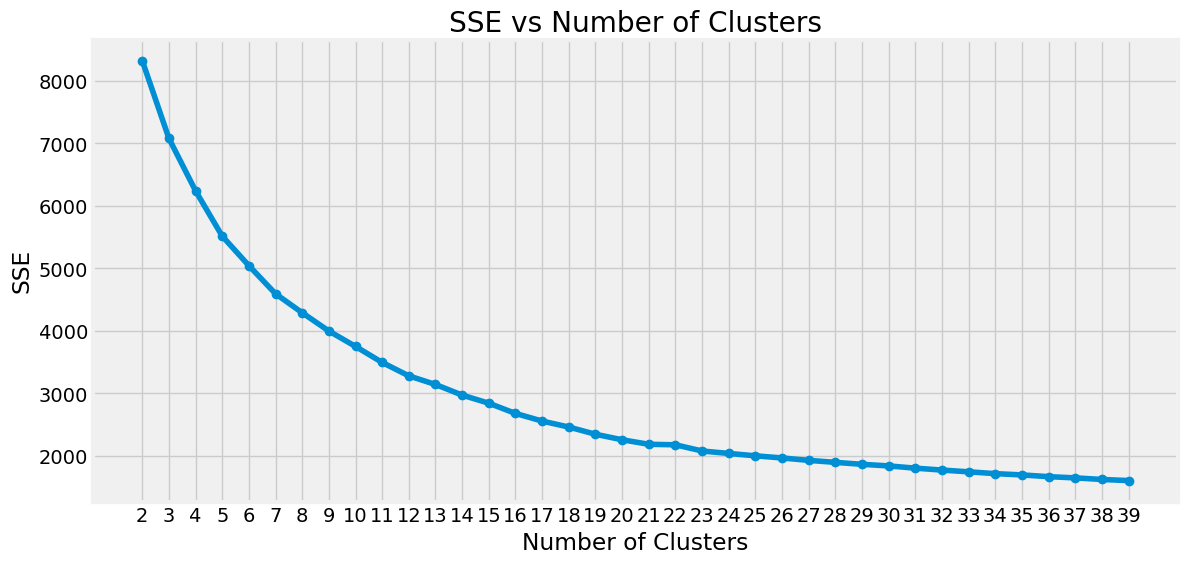

In [3]:
# using elbow method to find the optimal k
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Prepare data for clustering
select_columns = ['player1_x_norm', 'player1_y_norm', 'player2_x_norm', 'player2_y_norm', 'ball_type']
shots_2side = shots_2side.dropna(subset=select_columns)
X = shots_2side[select_columns]

sse = []
silhouette_scores = []
for k in range(2, 40):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(14, 6))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 40), sse, marker='o')
plt.xticks(range(2, 40))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("SSE vs Number of Clusters")
plt.show()

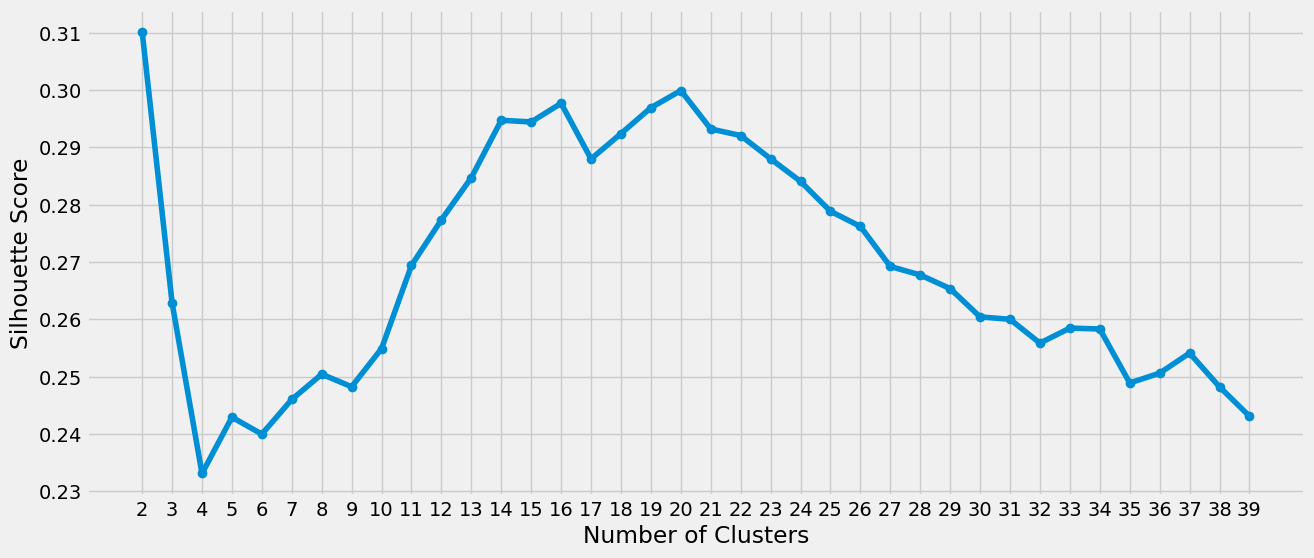

In [4]:
# using silhouette score to find the optimal k

from sklearn.metrics import silhouette_score

# sample before silhouette score since it takes a long time
sample = X.sample(frac=0.1, random_state=16)

silhouette_scores = []
for k in range(2, 40):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(sample)
    lables = kmeans.labels_
    score = silhouette_score(sample, lables)
    silhouette_scores.append(score)

plt.figure(figsize=(14, 6))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 40), silhouette_scores, marker='o')
plt.xticks(range(2, 40))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Start clustering
n = 8  # Number of clusters
kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
kmeans.fit(X)
shots_2side['cluster'] = kmeans.fit_predict(X)
cluster_counts = shots_2side['cluster'].value_counts()
print(shots_2side.shape)

print(cluster_counts)

mapping = {
    -1 : '發長球',
    -0.875 : '發短球',
    -0.75 : '挑球',
    -0.625 : '長球',
    -0.5 : '推撲球',
    -0.375 : '平球',
    -0.25 : '殺球',
    -0.125 : '切球',
    0 : '網前小球'
}
shots_2side['ball_type'] = shots_2side['ball_type'].replace(mapping)

balltype_crosstab = pd.crosstab(shots_2side['cluster'], shots_2side['ball_type'])
print(balltype_crosstab)



(63633, 15)
cluster
7    10615
3     9902
5     9795
0     8494
1     7959
4     7527
2     5376
6     3965
Name: count, dtype: int64
ball_type    切球    平球    挑球   推撲球    殺球   發短球  發長球  網前小球    長球
cluster                                                       
0             0     0  4257  1583     0  1635  229     0   790
1           787  1833     0    38  2065     0    0  3236     0
2           286  1048     0     0   407     0    0  3635     0
3          1670  2214     0     4  3676     0    0  2338     0
4             0     0  4286  1051     0   693   79     0  1418
5          1529  2382     0   178  3840     0    0  1864     2
6           597  1054     0   139  1570     0    0   531    74
7             0     0  6051  1396     0  1414  169     0  1585


C:\Users\vito\AppData\Local\Temp\ipykernel_3752\1703374319.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_2side['cluster'] = kmeans.fit_predict(X)
C:\Users\vito\AppData\Local\Temp\ipykernel_3752\1703374319.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shots_2side['ball_type'] = shots_2side['ball_type'].replace(mapping)


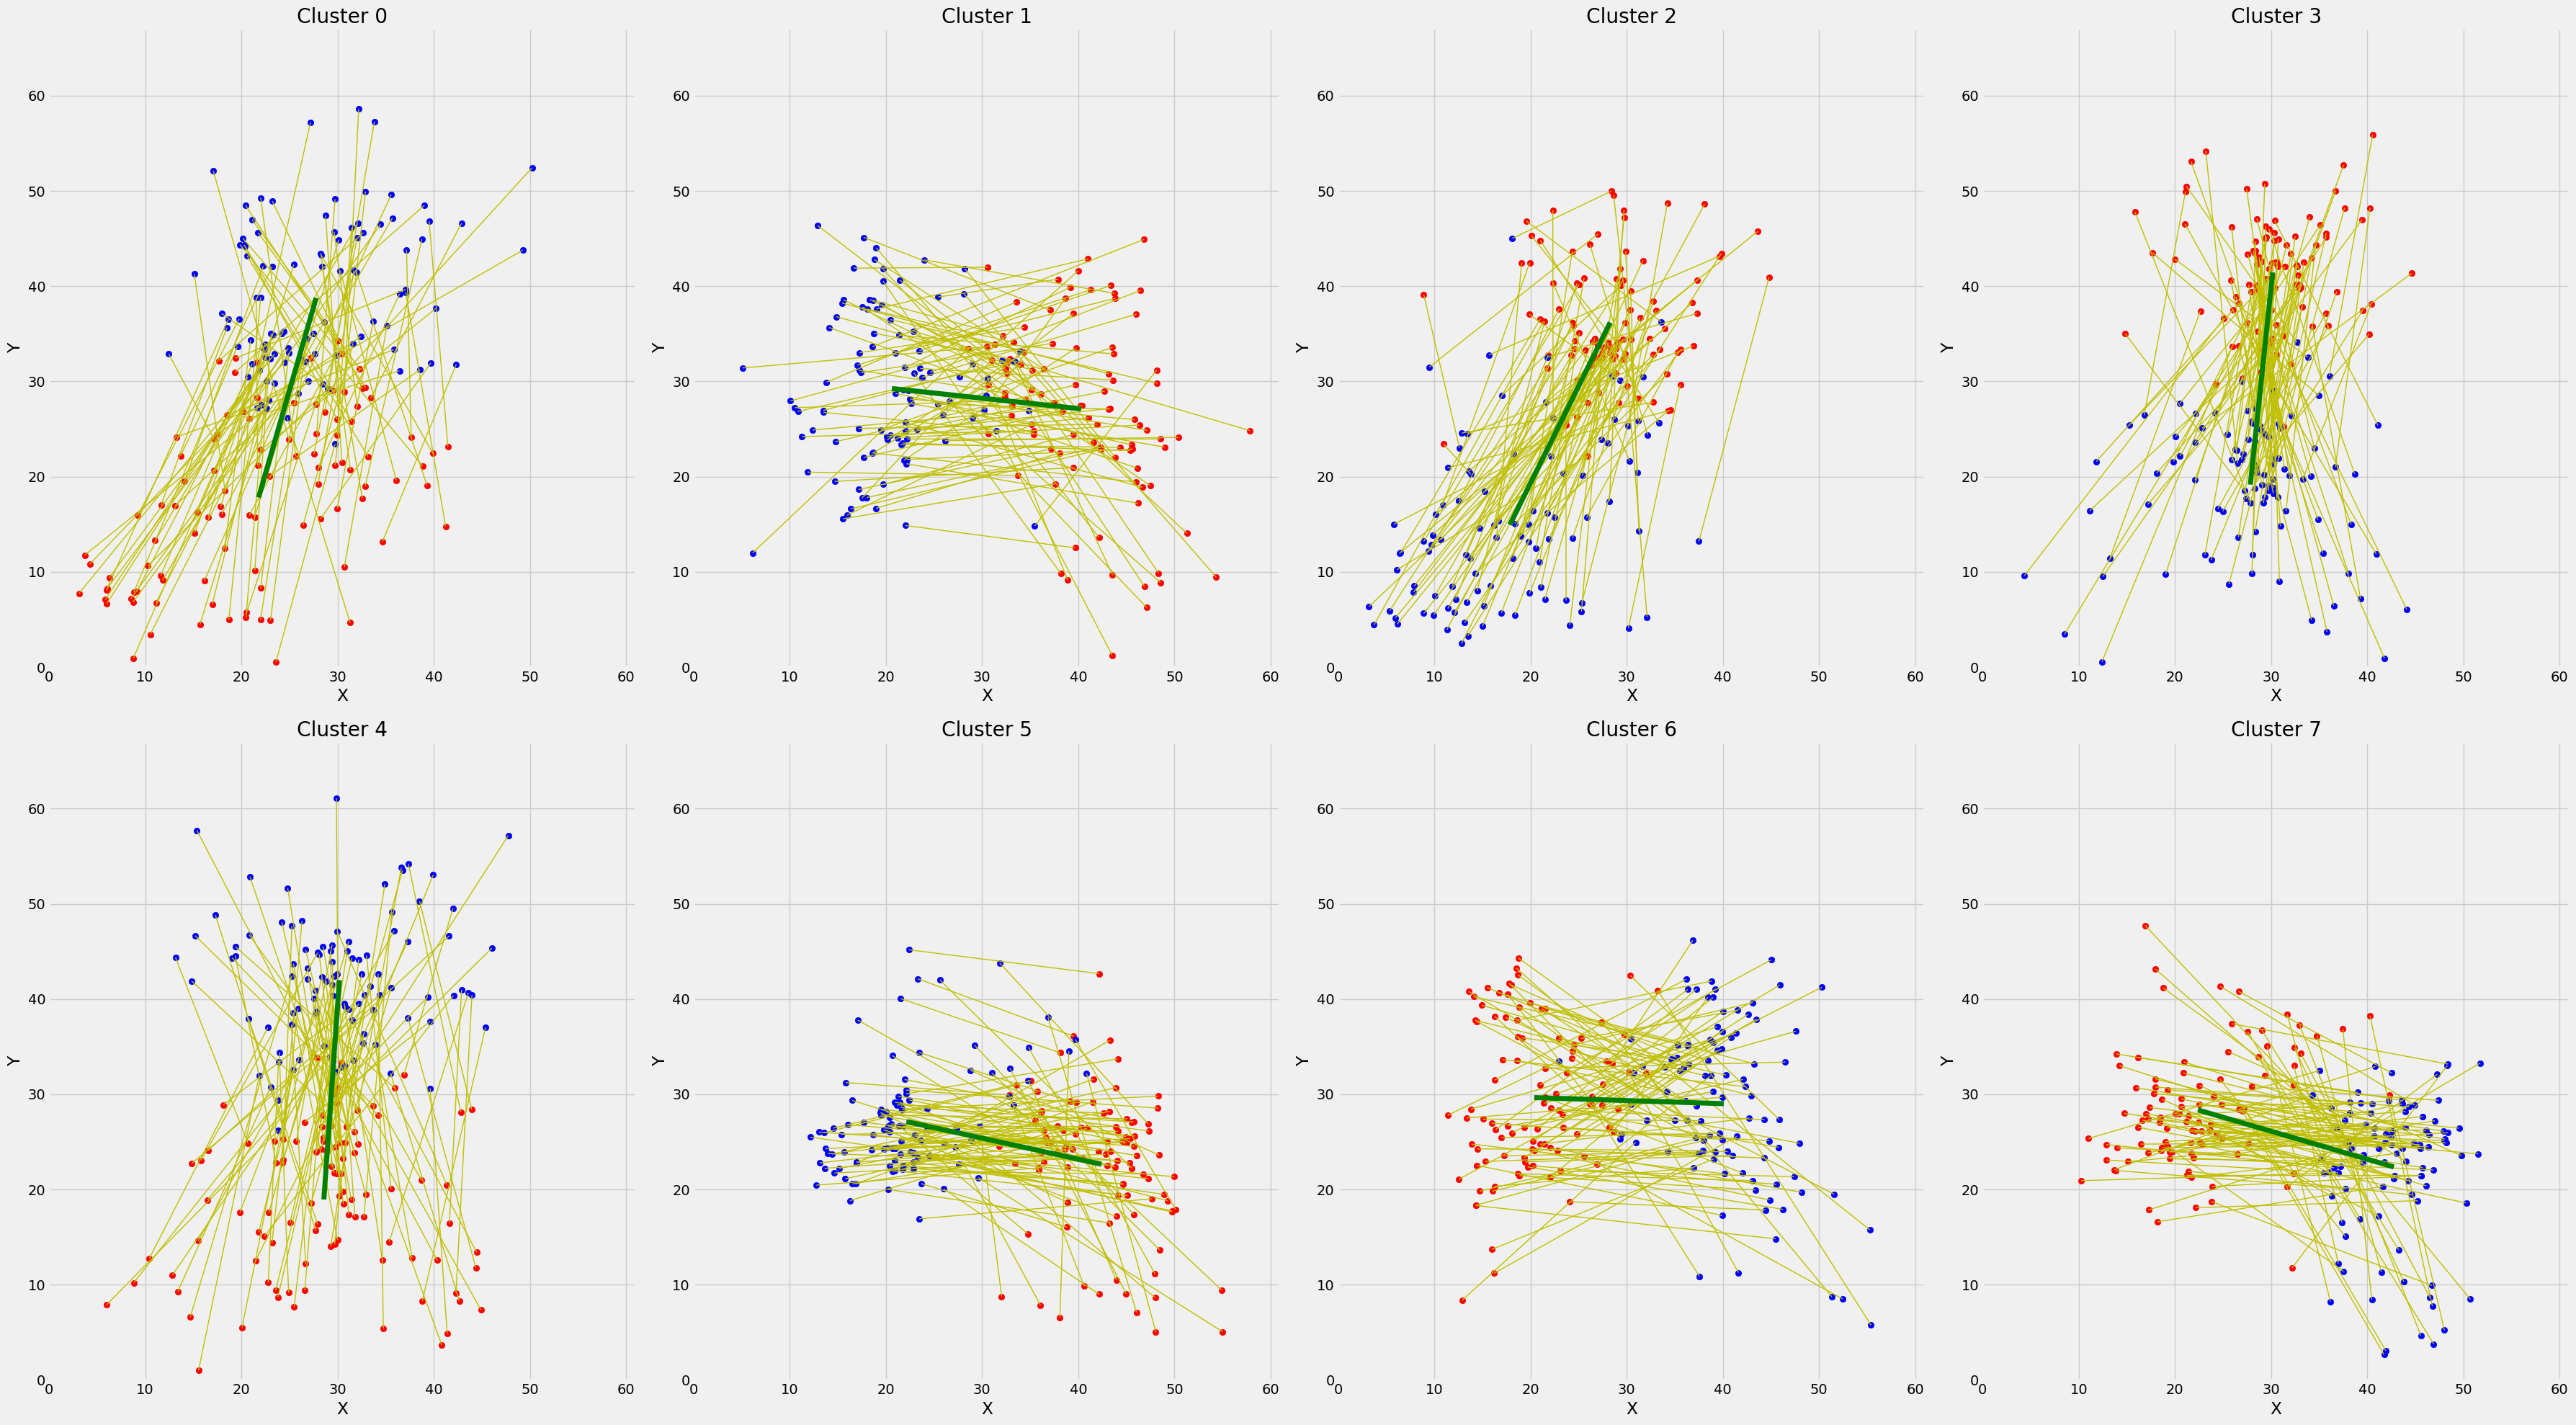

In [18]:
# Create a figure with 2x4 subplots
fig, axes = plt.subplots(2, 4, figsize=(36, 20))
axes = axes.flatten()  # Flatten to make iteration easier

for cluster in range(0, n):
    ax = axes[cluster]  # Select the subplot axis
    cluster_data = shots_2side[shots_2side['cluster'] == cluster]
    # If more than 100 points, sample data
    if len(cluster_data) > 100:
        sample_data = cluster_data.sample(n=100, random_state=41)
    else:
        sample_data = cluster_data

    # Plot Player 1
    ax.scatter(sample_data['player1_x'], sample_data['player1_y'], color='r', label=f'Cluster {cluster} - Player 1')
    # Plot partner line
    ax.plot([sample_data['player1_x'], sample_data['player2_x']], 
             [sample_data['player1_y'], sample_data['player2_y']], color='y', label=f'Cluster {cluster} - partner line', linewidth=1)
    # Plot Player 2
    ax.scatter(sample_data['player2_x'], sample_data['player2_y'], color='b', label=f'Cluster {cluster} - Player 2')
    # Plot center line
    ax.plot([sample_data['player2_x'].mean(), sample_data['player1_x'].mean()],
            [sample_data['player2_y'].mean(), sample_data['player1_y'].mean()], 
            color='g', label=f'Cluster {cluster} - center line', linewidth=5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(0, 61)
    ax.set_ylim(0, 67)
    ax.set_title(f'Cluster {cluster}')

    # # Save each subplot as an individual figure
    # individual_fig = plt.figure(figsize=(9.15, 10.05))
    # plt.scatter(sample_data['player1_x'], sample_data['player1_y'], color='r', label=f'Cluster {cluster} - Player 1')
    # plt.plot([sample_data['player1_x'], sample_data['player2_x']], 
    #          [sample_data['player1_y'], sample_data['player2_y']], color='y', label=f'Cluster {cluster} - partner line', linewidth=1)
    # plt.scatter(sample_data['player2_x'], sample_data['player2_y'], color='b', label=f'Cluster {cluster} - Player 2')
    # plt.plot([sample_data['player2_x'].mean(), sample_data['player1_x'].mean()],
    #          [sample_data['player2_y'].mean(), sample_data['player1_y'].mean()], 
    #          color='g', label=f'Cluster {cluster} - center line', linewidth=5)
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.xlim(0, 61)
    # plt.ylim(0, 67)
    # plt.title(f'Cluster {cluster}')
    # plt.savefig(f'cluster{cluster}.jpg')
    # plt.close(individual_fig)  # Close the individual figure after saving

# Adjust layout so the subplots don't overlap
plt.tight_layout()
# Save the entire figure
plt.savefig('all_clusters.jpg')
# Show the plot
plt.show()

